In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from collections import Iterable
import six

H_rad [  68.30777284  102.46165926  136.61554568  170.7694321   204.92331852
  239.07720494  273.23109136  307.38497778  341.5388642 ] TW
Q_cmb [  6.92956978   9.08030519  11.00000637  12.76437668  14.41408601
  15.97417001  17.46142168  18.88779593  20.26218497] TW
H_rad 136.615545679 TW
Q_cmb 11.00000636536881 TW
H_rad [  34.65772207   39.57368595   45.97649437   54.48361148   66.01387413
   81.95119682  104.40361683  136.61554568  183.62702141] TW
Q_cmb 11.00000636536881 TW


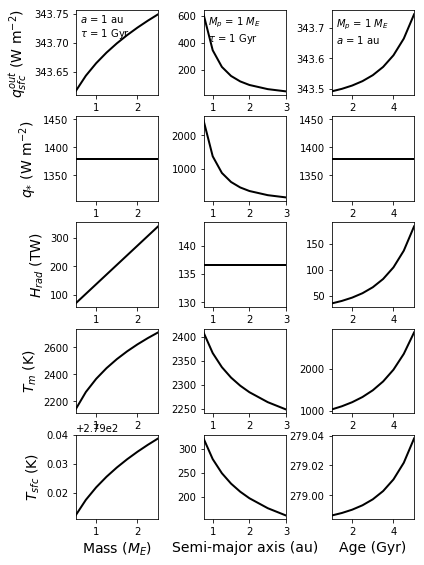

In [52]:
""" 0-D steady state model """

M_E = 5.972e24 # earth mass in kg
L_sun =  3.9e26 # solar luminosity in W
years2sec = 31557600
AU2m = 1.5e11
sb = 5.67e-8 # Stefan Boltzmann constant in W m^-2 K^-4

# Half-lives in years from Dye (2012) in Treatise on Geophys
t_40K_half = 1.26e9 
t_235U_half = 7.04e8 
t_238U_half = 4.46e9
t_232Th_half = 1.4e10

# Heating rates of radioisotopes per mass of isotope at tau=0 in W kg^-1 from Dye (2012) in Treatise on Geophys
h_40K_0 = 28.47e-6
h_235U_0 = 568.47e-6
h_238U_0 = 95.13e-6
h_232Th_0 = 26.3e-6

# radioisotope abundances
X_K = 250 # initial abundance of K in wt ppm (in Treatise on Geophysics, think these are by weight but double check)
X_U = 2e-2# initial abundane of U in wt ppm ""
X_Th = 7e-2 # initial abundance of Th in wt ppm ""
# TODO: are the below values in moles or mass? 
K_0 = 0.0117e-2 # ratio of 40-K to total K at time 0 (in Treatise on Geophysics)
U_0_235 = 0.0072 # ratio of 235-U to total U at time 0 (in Treatise on Geophysics)
U_0_238 = 0.9927 # ratio of 238-U to total U at time 0 (in Treatise on Geophysics)
Th_0 = 1 # ratio of 232-Th to total Th at time 0 (in Treatise on Geophysics)
H_0 = [h_40K_0, h_235U_0, h_238U_0, h_232Th_0]
X_0 = [X_K, X_U, X_U, X_Th]
el_0 = [K_0, U_0_235, U_0_238, Th_0]
t_half = [t_40K_half, t_235U_half, t_238U_half, t_232Th_half]

# thermodynamic parameters
nu_m = 1e20 # Mantle visc in Pa s
Ra_c = 660 # critical Rayleigh number (in Driscoll & Bercovici 2014)
C_pm = 800 # specific heat capacity of silicate mantle in J kg−1 K−1 (Elkins-Tanton+ 2011)
alpha_m = 2e-5 # thermal expansivity of silicate mantle in K^-1
k_m = 4 # thermal conductivity of silicate mantle in W m^−1 K^−1

L=1 # stellar luminosity in solar units
Alb=0
f_c = 0.2 #1220e3/6371e3 # core fraction in terms of radius
rho_c = 8000 # Density of iron core in kg m^-3 
rho_m = 4500 # Density of silicate mantle in kg m^-3
q_cmb = 11e12/(4*np.pi*1360624**2) # Heat flux across CMB in W m^-2, use earth value for now
#what is the right mantle density? low P highP?
#when doing these simple scalings, knowing the rock properties vary as a f(pt) 
#what p,t do we take the property at?

paramargs = dict(Alb=Alb, rho_m=rho_m, H_0=np.array(H_0), X_0=np.array(X_0)*1e-6, el_0=np.array(el_0), 
                 t_half=np.array(t_half)*years2sec, L=L*L_sun, nu_m=nu_m, Ra_c=Ra_c, C_pm=C_pm,
                 alpha_m=alpha_m, k_m=k_m, f_c=f_c, q_cmb=q_cmb)

def SA(M=None, rho=None, R=None, V=None):
    if R is None:
        if (V is None) and (M is not None) and (rho is not None):
            V = vol(M, rho)
        else:
            print('Missing mass or density to calculate volume')
        R = radius(V)
    return 4*np.pi*R**2

def radius(V):
    return (3*V/(4*np.pi))**(1/3)

def planet_radius(M_p, f_c, rho_m, rho_c):
    """Calculate radius of planet given total mass, assume lid (bndy layer) has the same density as mantle
    
    Parameters
    ----------
    M_p : float
        Mass of planet
    rho_m : float
        Mantle density
    F_c : float
        Core fraction in terms of radius
    rho_c : float
        Core density
    """
    
    R_p = ( 3*M_p/(4*np.pi) / (rho_m - f_c**3*rho_m + f_c**3*rho_c) )**(1/3)
    return R_p

def vol(M, rho):
    try:
        return M/rho
    except TypeError:
        return np.array(M)/np.array(rho)

def Q_star(L=None, Alb=None, a=None, **kwargs):
    """Calculate incident stellar flux density (over entire heliocentric sphere with radius a) in W m^-2"""
    return L*(1-Alb)/(4*np.pi*a**2) # 4pi is the total solid angle subtended by a sphere

def h_rad(tau=None, H_0=None, X_0=None, el_0=None, t_half=None, **kwargs):
    """Calculate radiogenic heating in W kg^-1"""
    if not isinstance(tau, Iterable):
        h = sum(H_0*X_0*el_0*np.exp(np.log(2)*tau/t_half))
    else:
        # for a list of ages
        h = np.zeros(len(tau))
        for ii, val in enumerate(tau):
            h[ii] = sum(H_0*X_0*el_0*np.exp(np.log(2)*val/t_half))
    return h

def q_out_ss(L=None, Alb=None, a=None, rho_m=None, M_p=None, tau=None, H_0=None,
             X_0=None, el_0=None, t_half=None, f_c=None, q_cmb=None, **kwargs):
    """Calculate steady-state surface flux density in W m^-2
    
    @ eq, Q_sfc = Q_star + Q_cond 
    where Q_cond = Q_rad + Q_cmb
    (total heat loss from top of mantle is equal to total radiogenic heating plus CMB flux)
    """
    if f_c==0:
        R_p = radius(vol(M_p, rho_m)) # planet radius based on mass and mantle density
    else:
        R_p = planet_radius(M_p, f_c, rho_m, rho_c)
    R_c = R_p*f_c # core radius
    SA_p = SA(M=M_p, rho=rho_m) # planet surface area
    SA_c = SA(R=R_c) # core surface area 
    
    Q_down = Q_star(L, Alb, a,)*(np.pi*R_p**2) # in W
    Q_up = h_rad(tau, H_0, X_0, el_0, t_half)*M_p + q_cmb*SA_c # in W
    print('H_rad', h_rad(tau, H_0, X_0, el_0, t_half)*M_p*1e-12, 'TW')
    print('Q_cmb', q_cmb*SA_c*1e-12, 'TW')
    Q_bb = Q_down + Q_up # in W
    #print('Q_bb out = Q_* + Q_cond = ',Q_bb,'W')
    #print('SA', SA(M_p, rho_m), 'm^2')
    q_bb = Q_bb/SA_p # divide by total emitting area to get flux density
    return q_bb

def thermal_diffusivity(k, rho, C_p):
    """
    Calculate thermal diffusivity
    
    Parameters
    ----------
    k : Thermal conductivity
    C_p : Specific heat capacity in J K^-1 kg^-1
    rho : density in kg m^-3
    """
    #print('kappa', k/(rho*C_p), 'm^2 s^-1')
    return k/(rho*C_p)

def grav(M, R):
    """Calculate acceleration due to gravity on a point mass in m s^-2"""
    return 6.674e-11*M/R**2

def lid_thickness(T_s=None, T_m=None, Ra_c=None, nu_m=None, alpha_m=None, 
                  rho_m=None, g=None, **kwargs):
    """Thickness of uppper mantle thermal boundary layer 
    
    Parameters
    ----------
    T_s : float
        Surface temperature
    Ra_c : float
        Critical Rayleigh number
    alpha_m : float 
        Thermal expansivity in
    kappa : float 
        Thermal diffusivity in
    nu_m : float
        Mantle viscosity in
    g : float
        Acceleration due to gravity in m s^-2
    
        
    Returns
    -------
    d : float
        Lid thickness in m
    """
    
    kappa_m=thermal_diffusivity(k_m, rho_m, C_pm)
    
    # Set Rayleigh number at critical value
    d = (Ra_c * nu_m*kappa_m/(alpha_m*rho_m*g*(T_m - T_s)))**(1/3)
    return d

def T_sfc(q_out=None, **kwargs):
    """Calculate equilibrium surface temperature given outgoing radiation in W m^-2"""
    return (q_out/sb)**(1/4)

def T_mtl(k_m=None, rho_m=None, alpha_m=None, C_pm=None, M_p=None, Ra_c=None, nu_m=None,
          q_out=None, Q_bl=None, **kwargs): 
    """Calculate mantle temperature"""
    kappa_m = thermal_diffusivity(k_m, rho_m, C_pm)
    T_s = T_sfc(q_out)
    g_sfc = grav(M_p, radius(vol(M_p, rho_m)))
    C = SA(M_p, rho_m)*k_m / ((Ra_c*nu_m*kappa_m)/(alpha_m*rho_m*g_sfc))**(1/3)
    T_m = (Q_bl/C)**(3/4) + T_s
    return T_m

def plot_one(ax, x, y, xlabel, ylabel, labelsize, legsize, lw=1, c='k', text=None, **kwargs):
    ax.set_xlabel(xlabel, fontsize=labelsize)
    ax.set_ylabel(ylabel, fontsize=labelsize)
    ax.plot(x, y, c=c, lw=lw)
    ax.set_xlim(x.min(), x.max())
    if text is not None:
        ax.text(0.05, 0.95, text, ha='left',va='top', transform=ax.transAxes, fontsize=legsize)
    return ax

def plt_flux_multi(n_cols, wspace, hspace, *args, **kwargs):
    fig, axes = plt.subplots(5, n_cols, figsize=(2*n_cols, 8))
    ii = 0
    while ii < n_cols: # for each x variable column (make 3 rows)
        
        kwargs_i = kwargs.copy()
        for name, value in kwargs_i.items():
            if (isinstance(value, Iterable) and not isinstance(value, six.string_types) 
                    and not (name=='H_0' or name=='el_0' or name=='X_0' or name=='t_half'
                            or name=='ylabels')):
                # i.e. for each subplot col if different
                kwargs_i[name] = value[ii]
        xs = list(kwargs_i.values())[ii]
        xnorm = kwargs_i['xnorm']
        kwargs_i['ylabel']=''
        kwargs_i['text']=None
        
        q_out = q_out_ss(**kwargs_i)
        q_s = Q_star(**kwargs_i) # instellation in W m^-2
        H_rad = h_rad(**kwargs_i)*M_p[ii] # radiogenic heating in W
        Q_bl = H_rad # flux across boundary layer in W
        q_bl = Q_bl/SA(M_p[ii], rho_m) # flux density across boundary layer in W m^-2
        
        # sfc temperatures
        ax = axes[4][ii]
        T_s = T_sfc(q_out=q_out, **kwargs_i)
        if ii==0:
            # only label leftmost col
            kwargs_i['ylabel']=kwargs_i['ylabels'][4]
        try:
            ax = plot_one(ax, xs*xnorm, T_s, **kwargs_i)
        except ValueError:
            # if scalar
            ax = plot_one(ax, xs*xnorm, [T_s]*len(xs), **kwargs_i)
            
        # mantle temperatures
        ax = axes[3][ii]
        kwargs_i['xlabel']=''
        T_m = T_mtl(q_out=q_out, Q_bl=Q_bl, **kwargs_i)
        if ii==0:
            # only label leftmost col
            kwargs_i['ylabel']=kwargs_i['ylabels'][3]
        try:
            ax = plot_one(ax, xs*xnorm, T_m, **kwargs_i)
        except ValueError:
            # if scalar
            ax = plot_one(ax, xs*xnorm, [T_m]*len(xs), **kwargs_i)
        
        # rad heating
        ax = axes[2][ii]
        kwargs_i['xlabel']=''
        if ii==0:
            # only label leftmost col
            kwargs_i['ylabel']=kwargs_i['ylabels'][2]
        try:
            ax = plot_one(ax, xs*xnorm, H_rad*1e-12, **kwargs_i)
        except ValueError:
            # if scalar
            ax = plot_one(ax, xs*xnorm, [H_rad*1e-12]*len(xs), **kwargs_i)
          
        # insolation flux density
        ax = axes[1][ii]
        kwargs_i['xlabel']=''
        if ii==0:
            # only label leftmost col
            kwargs_i['ylabel']=kwargs_i['ylabels'][1]
        try:
            ax = plot_one(ax, xs*xnorm, q_s, **kwargs_i)
        except ValueError:
            # if scalar
            ax = plot_one(ax, xs*xnorm, [q_s]*len(xs), **kwargs_i)
        
        # flux out of surface (bb)
        ax = axes[0][ii]
        kwargs_i['xlabel']=''
        kwargs_i['text']=kwargs['text'][ii]
        if ii==0:
            # only label leftmost col
            kwargs_i['ylabel']=kwargs_i['ylabels'][0]
        ax = plot_one(ax, xs*xnorm, q_out, **kwargs_i)
        
        ii += 1
        
    plt.tight_layout()
    plt.subplots_adjust(wspace=wspace, hspace=hspace)
    return fig, axes     


M_p_0 = 1 # M_E
a_0 = 1 # AU
age_0 = 4.5 # Gyr

M_p_vec = [0.5, 0.75, 1, 1.25, 1.5, 1.75, 2, 2.25, 2.5] # M_E
a_vec = [0.75, 1, 1.25, 1.5, 1.75, 2, 2.5, 3] # AU
age_vec = [1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5] # Gyr

M_p = [np.array(M_p_vec)*M_E, M_p_0*M_E, M_p_0*M_E] # kg
a = [a_0*AU2m, np.array(a_vec)*AU2m, a_0*AU2m] # m
tau = [age_0*1e9*years2sec, age_0*1e9*years2sec, np.array(age_vec)*1e9*years2sec] # s
varargs = dict(M_p=M_p, a=a, tau=tau)

xlabel=['Mass ($M_E$)', 'Semi-major axis (au)', 'Age (Gyr)']
texty=['$a$ = '+str(a_0)+' au\n'+r'$\tau$'+' = '+str(age_0)+' Gyr',
      '$M_p$ = '+str(M_p_0)+' $M_E$\n'+r'$\tau$'+' = '+str(age_0)+' Gyr',
      '$M_p$ = '+str(M_p_0)+' $M_E$\n$a$ = '+str(a_0)+' au']
rowcolour=['k']*3 # one colour per row
# ylabels=['Surface flux density (W m$^{-2}$)', 
#          'Stellar flux density (W m$^{-2}$)',
#          'Radiogenic heating (TW)',
#          'Mantle temperature (K)', 'Surface temperature (K)']
ylabels=['$q_{sfc}^{out}$ (W m$^{-2}$)', 
         '$q_{*}$ (W m$^{-2}$)',
         '$H_{rad}$ (TW)',
         '$T_m$ (K)', '$T_{sfc}$ (K)']
xnorm=[M_E**-1, AU2m**-1, years2sec**-1*1e-9, 1, 1]

pltargs=dict(labelsize=14, legsize=10, lw=2, wspace=0.55, hspace=0.25,
             ylabels=ylabels, xlabel=xlabel, c=rowcolour, xnorm=xnorm, 
             text=texty)

fig, _ = plt_flux_multi(n_cols=len(varargs), **varargs, **paramargs, **pltargs)
fig.savefig('figs/ss_fluxes.pdf', bbox_inches='tight')

# TODO: parameterize as ratios to Earth values / non-dimensionalization?
 